In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Necessary imports

In [11]:
import pandas as pd
import numpy as np
# import tensorflow as wtf  # just kidding
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import torch

!pip install --quiet vit-keras
from vit_keras import vit

TensorFlow Version 2.6.4


# Orange mission

## Simple binary classification: the image has error or not

### Static variables

In [12]:
from sklearn.model_selection import train_test_split
TRAIN_PATH: str = '/kaggle/input/images-with-errors-eurecat/A2/'
train_df: pd.DataFrame = pd.read_csv('/kaggle/input/images-with-errors-eurecat/A2/train-hackeps.csv', index_col=0)
train_df['path'] = train_df['path'].apply(lambda x: "/".join(x.split('/')[3:]))

target_column: str = 'status'  # status of the texture, with error or not
target_classes: list = ['perfect', 'defect']

columns_to_drop = list(train_df.columns[-6:])
train_df[target_column] = train_df[columns_to_drop].apply(lambda x: target_classes[1] if np.sum(x.values) > 0 else target_classes[0], axis=1)
train_df.drop(columns_to_drop, axis=1, inplace=True)

IMG_SIZE: tuple = Image.open(TRAIN_PATH + train_df['path'].iloc[0])._size
BATCH_SIZE: int = 16
    
train_df, test_df = train_test_split(train_df, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.4)  
train_df = pd.concat([train_df for _ in range(8)], axis=0)

_n_perfect = 100 * np.count_nonzero(train_df.where(train_df['status'] == 'perfect', other=0)) / len(train_df)
print("The", np.round(_n_perfect, 2), 'are perfect (no defects)')
print("We are in front of an imbalanced problem, we could do oversampling with SMOTE.")
print("But it would require to hash and onehot/label encode the categorical features")
# from imblearn.over_sampling import SMOTE

train_df

The 83.04 are perfect (no defects)
We are in front of an imbalanced problem, we could do oversampling with SMOTE.
But it would require to hash and onehot/label encode the categorical features


,Unnamed: 0.1,name,path,status
264,15,c1r3e3n31,c1/r3/images/e3/c1r3e3n31.tif,defect
668,19,c1r1e3n11,c1/r1/images/e3/c1r1e3n11.tif,defect
520,21,c2r3e1n49,c2/r3/images/e1/c2r3e1n49.tif,defect
213,14,c2r3e3n12,c2/r3/images/e3/c2r3e3n12.tif,defect
731,32,c1r1e2n3,c1/r1/images/e2/c1r1e2n3.tif,defect
...,...,...,...,...
667,18,c1r1e3n46,c1/r1/images/e3/c1r1e3n46.tif,defect
663,14,c1r1e3n41,c1/r1/images/e3/c1r1e3n41.tif,defect
168,20,c1r1e0n50,c1/r1/images/e0/c1r1e0n50.tif,perfect
154,5,c1r1e0n16,c1/r1/images/e0/c1r1e0n16.tif,perfect


#### We synthetically duplicate the training dataframe to have more samples, avoiding overfitting using:
- Early stopping
- Data augmentation: i.e. is not probable the model sees 2 images duplicated; they suffer random transformations to make the model generalize better

# Data pipeline (TF with data augmentation)

### Data augmentation

In [13]:
def resizing(image: tf.image) -> tf.image:
    # We need to ensure all the images are squared... (for the transformer) 
    image = tf.image.resize(image, (min(IMG_SIZE), min(IMG_SIZE)),
                            preserve_aspect_ratio=False, 
                            antialias=False, name=None)
    return image

def data_augmentation(image: tf.image) -> tf.image:
    """
    Based on random probabilities, perform different kind of augmenations on an image. 

    Parameters
    ----------
    images: tf.image
        Image corresponding to the set.

    Returns
    -------
    tf.image: An augmented image. 
        
            
    """

    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
    
    # We need to ensure all the images are squared... 
    image = resizing(image)
    
    return image

In [14]:
# from now on we can assume the images are squared 
IMG_SIZE = (min(IMG_SIZE), min(IMG_SIZE))
IMG_SIZE

(512, 512)

# Data pipeline

## Training pipeline

### **Important**: the pre-trained models require images not scaled! That's why the option ``rescale = 1./255`` is missing in the ImageDataGenerator 

In [15]:
_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True, samplewise_std_normalization = False,
    preprocessing_function = data_augmentation)
    
train_pipeline = _train_datagen.flow_from_dataframe(
    dataframe = train_df, directory=TRAIN_PATH, 
    x_col = 'path', y_col = target_column, # subset='training',
    batch_size=BATCH_SIZE, seed=np.random.randint(50), color_mode='rgb',
    shuffle = True, class_mode = 'categorical', target_size = IMG_SIZE)


_valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True, samplewise_std_normalization = False,
    preprocessing_function = resizing)
    
valid_pipeline = _valid_datagen.flow_from_dataframe(
    dataframe = valid_df, directory=TRAIN_PATH, 
    x_col = 'path', y_col = target_column, # subset='validation',
    batch_size=BATCH_SIZE, seed=np.random.randint(50), color_mode='rgb',
    shuffle = True, class_mode = 'categorical', target_size = IMG_SIZE)

_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True, samplewise_std_normalization = False,
    preprocessing_function = resizing)
    
test_pipeline = _test_datagen.flow_from_dataframe(
    dataframe = test_df, directory=TRAIN_PATH, 
    x_col = 'path', y_col = target_column,
    batch_size=BATCH_SIZE, seed=np.random.randint(50), color_mode='rgb',
    shuffle = True, class_mode = 'categorical', target_size = IMG_SIZE)

Found 2672 validated image filenames belonging to 2 classes.
Found 223 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.


## We check it works by plotting some of the images

In [16]:
from PIL import Image
im = Image.open('/kaggle/input/images-with-errors-eurecat/A2/c2/r3/images/e2/c2r3e2n21.tif')
# im

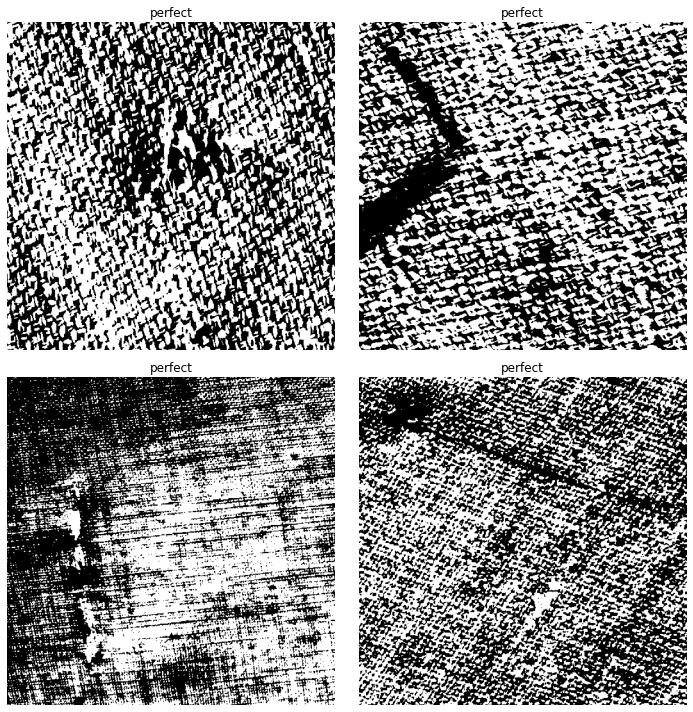

In [40]:
# Plot a grid of images.
PLOT_IMAGES = 4
images = []
labels_class = []

_image_j = PLOT_IMAGES
while _image_j > 0:
    _train_gen = train_pipeline

    _I_BATCH = np.random.randint(len(_train_gen) // BATCH_SIZE)
    i = np.random.randint(BATCH_SIZE)
    images.append(_train_gen[_I_BATCH][0][i]) # n Images from train generator.
    labels_class.append(target_classes[int(np.argwhere(_train_gen[_I_BATCH][1][i] > 0))]) # The correspondent name
    _image_j -= 1
    
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()

for img, ax, lab in zip(images, axes, labels_class):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(lab)
plt.tight_layout()
plt.show()

# Transformer training

## Import pretrained VIT model from Keras

In [41]:
# pretrained_model = vit.vit_b16(
#         image_size = IMG_SIZE[0],
#         activation = 'softmax',
#         pretrained = True,
#         include_top = False,
#         pretrained_top = False,
#         classes = len(target_classes))
# pretrained_model.trainable = False

# model = tf.keras.Sequential([
#             pretrained_model,
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dense(len(target_classes) // 2, activation = tfa.activations.gelu),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dense(1, 'softmax')
#         ], name = f'transfer_learning')

## Import pretrained CNN model from Keras

In [42]:
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras import layers

def get_cnn_model(batch_normalization: bool = True, dropout_rate: float = 0.) -> tf.keras.Model:
    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    pretrained_model = EfficientNetB6(include_top=False, input_tensor=inputs, weights="imagenet")
    # freeze the pretrained weights
    pretrained_model.trainable = False
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(pretrained_model.output)
    
    if batch_normalization:
        x = layers.BatchNormalization()(x)  
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)
    
    fcc_layer = layers.Dense(len(target_classes), activation="softmax", name="pred")
    outputs = fcc_layer(x)
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

### We use transfer learning to fine-tune the last layers

In [43]:
model = get_cnn_model()
# model.summary()  # it is really long in case of the CNN

165249024/165234480 [==============================] - 1s 0us/step


## Compiling the model 

In [44]:
optimizer = 'adam'  # tfa.optimizers.RectifiedAdam(learning_rate=5e-2) # Creates the optimizer using rectified ADAM.
_loss_function = 'BCE'  # tf.keras.losses.BinaryCrossentropy(from_logits=False)  # 'logloss'  # 'BCE'

In [45]:
model.compile(optimizer=optimizer, loss = _loss_function, metrics = ['accuracy', 'AUC'])

STEP_SIZE_TRAIN = train_pipeline.n // train_pipeline.batch_size
STEP_SIZE_VALID = valid_pipeline.n // valid_pipeline.batch_size

# Dynamic Learning Rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'min')
# Early stopping
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 min_delta = 1e-4,
                                                 patience = 3,
                                                 mode = 'min',
                                                 restore_best_weights = True,
                                                 verbose = 1)
# Checkpoint. Save the model.
# checkpointer = tf.keras.callbacks.ModelCheckpoint(
#     filepath = '/kaggle/working/model.hdf5', monitor = 'val_accuracy', verbose = 1, 
#     save_best_only = True, save_weights_only = True, mode = 'max')

callbacks = [earlystopping, reduce_lr]  # , ]  # , checkpointer] # Our callbacks

## Training the model

In [ ]:
import shutil
EPOCHS: int = 8

history = model.fit(
    x=train_pipeline, steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_pipeline, validation_steps=STEP_SIZE_VALID,
    callbacks=callbacks, epochs=EPOCHS,  # EPOCHS,
    )

model.save('/kaggle/working/serialized_model')
shutil.make_archive('/kaggle/working/serialized_model', 'zip', '/kaggle/working/')

2022-11-27 03:46:18.341930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8


2022-11-27 03:46:35.209794: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 31/167 [====>.........................] - ETA: 2:09 - loss: 0.5359 - accuracy: 0.7440 - auc: 0.8158

## Inference 

In [124]:
from tensorflow.keras.models import load_model
_loaded_model = load_model('/kaggle/working/serialized_model')
y_prob_train = _loaded_model.predict(train_pipeline, steps = train_pipeline.n // train_pipeline.batch_size + 1)
y_prob_valid = _loaded_model.predict(valid_pipeline, steps = valid_pipeline.n // valid_pipeline.batch_size + 1)
y_prob_test = _loaded_model.predict(test_pipeline, steps = test_pipeline.n // test_pipeline.batch_size + 1)

## Result analysis & plots

In [ ]:
predicted_classes_train = np.argmax(y_prob_train, axis = 1)
predicted_classes_valid = np.argmax(y_prob_valid, axis = 1)
predicted_classes_test = np.argmax(y_prob_test, axis = 1)

# class_labels = list(true_pipeline.class_indices.keys())  

print('\n' + 3 * "---", 'TRAIN', 3 * '---')
print(classification_report(train_pipeline.classes, predicted_classes_train))
print('\n' + 3 * "---", 'VALIDATION', 3 * '---')
print(classification_report(valid_pipeline.classes, predicted_classes_valid))
print('\n' + 3 * "---", 'TEST', 3 * '---')
print(classification_report(test_pipeline.classes, predicted_classes_test))

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Training

In [ ]:
confusionmatrix = confusion_matrix(train_pipeline.classes, predicted_classes_train)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

#### Validation

In [ ]:
confusionmatrix = confusion_matrix(valid_pipeline.classes, predicted_classes_valid)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

#### Test

In [ ]:
confusionmatrix = confusion_matrix(test_pipeline.classes, predicted_classes_test)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

### ROC curve

In [ ]:
def compute_roc_and_auc(y_true,  y_pred_proba):
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    return fpr, tpr, auc

In [ ]:
fpr_train, tpr_train, auc_train = compute_roc_and_auc(train_pipeline.classes, y_prob_train)
fpr_valid, tpr_valid, auc_valid = compute_roc_and_auc(valid_pipeline.classes, y_prob_valid)
fpr_test, tpr_test, auc_test = compute_roc_and_auc(test_pipeline.classes, y_prob_test)

#create ROC curve
plt.plot(fpr_train, tpr_train, label=f"Train AUC="+str(auc_train))
plt.plot(fpr_valid, tpr_valid, label=f"Validation AUC="+str(auc_valid))
plt.plot(fpr_test, tpr_test, label=f"Test AUC="+str(auc_test))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()